In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [27]:
SCALER = 'MINMAX'
LAST_N = -15

In [28]:
df = pd.read_csv('total.csv')
df.head()

,Date,S&P,currency,gold,kospi,kospi_shift
0,2003-12-01,1070.119995,1198.400024,402.700012,807.390015,807.780029
1,2003-12-02,1066.619995,1195.000000,403.700012,807.780029,808.340027
2,2003-12-03,1064.729980,1192.500000,403.899994,808.340027,805.130005
3,2003-12-04,1069.719971,1190.099976,403.299988,805.130005,789.409973
4,2003-12-05,1061.500000,1184.699951,406.399994,789.409973,784.799988


In [29]:
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5322,2024-04-24,5071.629883,1370.479980,2324.500000,2675.750000,2628.620117
5323,2024-04-25,5048.419922,1376.969971,2329.800049,2628.620117,2656.330078
5324,2024-04-26,5099.959961,1371.699951,2334.800049,2656.330078,2705.139893
5325,2024-04-29,5116.169922,1377.089966,2345.800049,2656.330078,2705.139893
5326,2024-04-30,5116.169922,1377.089966,2345.800049,2705.139893,2705.139893


In [30]:
# df = df.drop('Date', axis=1)
df_1 = df.iloc[:LAST_N, :].copy()
# df_1 = df_1.drop('Date', axis=1)
df_1 = df_1.drop(['Date', 'kospi'], axis=1)
print(df_1.tail())
# train_x, test_x, train_y, test_y = train_test_split(df_1.loc[:, 'S&P':'kospi'], df_1.loc[:, 'kospi_shift'], train_size=0.9)
train_x, test_x, train_y, test_y = train_test_split(df_1.loc[:, 'S&P':'gold'], df_1.loc[:, 'kospi_shift'], train_size=0.9)
col_names = df_1.columns.values
print(col_names)

              S&P     currency         gold  kospi_shift
5307  5211.490234  1350.729980  2294.399902  2742.000000
5308  5147.209961  1344.839966  2288.800049  2714.209961
5309  5204.339844  1351.359985  2325.699951  2717.649902
5310  5202.390137  1350.270020  2331.699951  2705.159912
5311  5209.910156  1354.219971  2343.500000  2706.959961
['S&P' 'currency' 'gold' 'kospi_shift']


In [31]:
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[:-1]:
    scale_params[i] = [train_x[i].mean(), train_x[i].var(), train_x[i].max(), train_x[i].min()]
scale_params

,S&P,currency,gold
mean,2.171741e+03,1128.995667,1246.169121
var,1.265535e+06,12335.475344,214792.684741
max,5.254350e+03,1571.400024,2343.500000
min,6.765300e+02,886.679993,374.799988


In [32]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,S&P,currency,gold
900,0.180571,0.053642,0.149185
4558,0.760753,0.355897,0.765480
4045,0.451726,0.439873,0.481485
1367,0.019304,0.918507,0.300147
5079,0.767931,0.654370,0.814700


In [33]:
xgb = XGBRegressor()
lgbm = LGBMRegressor()
rf = RandomForestRegressor(random_state = 0, n_jobs = -1)
model_list = [xgb, lgbm, rf]

In [34]:
# XGB
param_xgb = {"max_depth": [10, 30, 50],
              "min_child_weight" : [1, 3, 6, 10],
              "n_estimators": [100, 200, 300, 500, 1000]
              }    
# LGB                        
param_lgbm = {"learning_rate" : [0.01, 0.1, 0.2, 0.5],
             "max_depth" : [25, 50, 75],
             "num_leaves" : [100, 300, 500, 1000],
             "n_estimators" : [100, 200, 300, 500, 1000],
             "learning_rate" : [0.01, 0.1, 0.2, 0.5]
              }
params_rf = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }
params_list = [param_xgb, param_lgbm, params_rf]

In [35]:
grid_result = pd.DataFrame(columns=['xgb', 'lgbm', 'rf'], index=['params', 'best'])

for i in range(len(model_list)):
    grid_model = GridSearchCV(estimator=model_list[i], param_grid=params_list[i], scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    grid_model.fit(train_x, train_y)
    # grid_result.iloc[0, i] = grid_model.best_params_
    # grid_result.iloc[1, i] = grid_model.best_score_
    print(grid_model.best_params_)
    print(grid_model.best_score_)

grid_result

{'max_depth': 30, 'min_child_weight': 10, 'n_estimators': 100}
-2357.46188822283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4780, number of used features: 3
[LightGBM] [Info] Start training from score 1936.341533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 200, 'num_leaves': 100}
-2491.777645926017
{'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
-2986.5120412158394


,xgb,lgbm,rf
params,NaN,NaN,NaN
best,NaN,NaN,NaN


In [36]:
# model = RandomForestRegressor(n_estimators=100, max_depth=12, min_samples_leaf=16, min_samples_split=8, random_state=99)
model = LGBMRegressor(learning_rate=0.2, max_depth=75, n_estimators=100, num_leaves=100)
model.fit(train_data, train_y)
pred = model.predict(test_data)

result = mean_squared_error(test_y, pred)
result

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4780, number of used features: 3
[LightGBM] [Info] Start training from score 1936.341533


2441.650329405264

In [37]:
# model.booster_.feature_importance(importance_type='gain')

gold        2.496349e+09
S&P         1.104454e+09
currency    2.228457e+08
dtype: float64


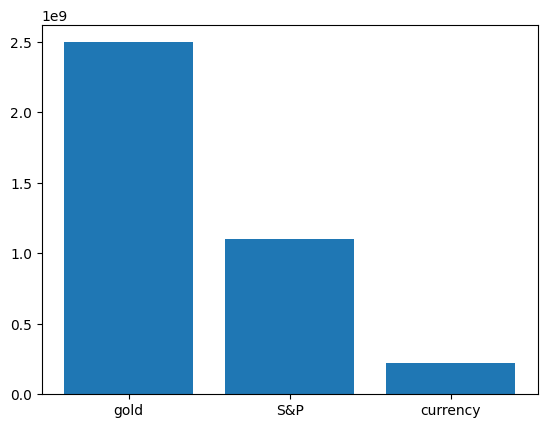

In [38]:
# model_importances = pd.Series(rf.feature_importances_, index = train_x.columns)
model_importances = pd.Series(model.booster_.feature_importance(importance_type='gain'), index = train_x.columns)
plt.bar(model_importances.sort_values(ascending=False).index, model_importances.sort_values(ascending=False))
print(model_importances.sort_values(ascending=False))
plt.show()

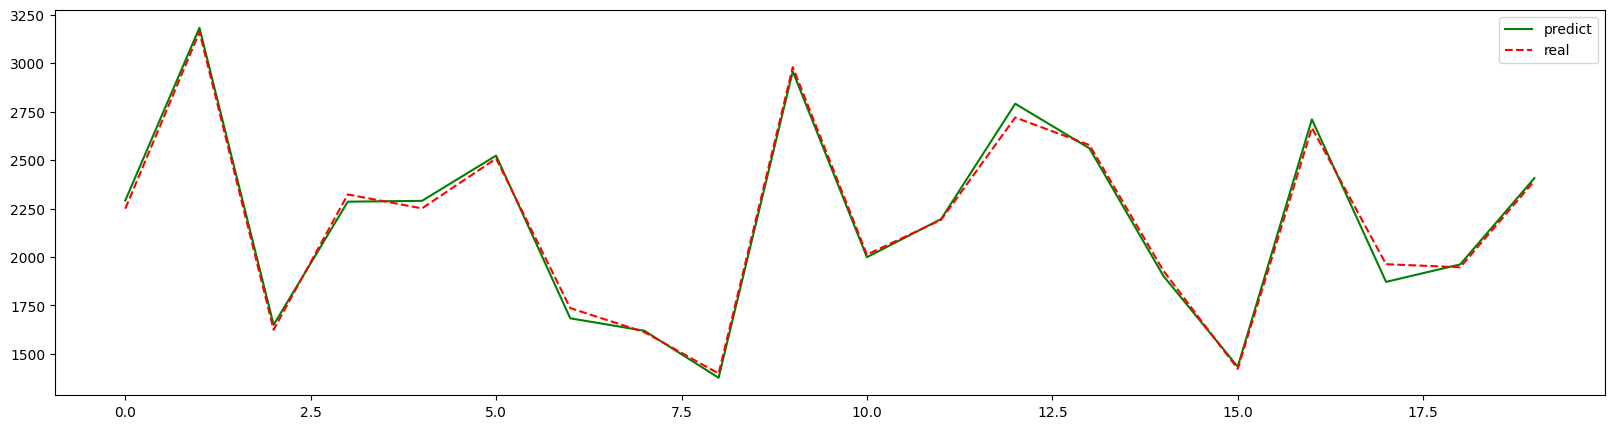

In [39]:
plt.figure(figsize=(20, 5))
plt.plot(pred[-50:-30], 'g-', label='predict')
plt.plot(test_y[-50:-30].values, 'r--', label='real')
plt.legend()
plt.show()

In [40]:
# recent untested data prediction
for i in col_names[:-1]:
    # input = df.iloc[LAST_N:, 1:].drop('kospi_shift', axis=1).apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
    input = df.iloc[LAST_N:, 1:].drop(['kospi', 'kospi_shift'], axis=1).apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
pred_last = model.predict(input)
df_pred = pd.DataFrame(columns=['y', 'pred', 'diff'])
df_pred['pred'] = pred_last
df_pred['y'] = df.iloc[LAST_N:, -1:].values
df_pred['diff'] = df_pred['y'] - df_pred['pred']
df_pred

,y,pred,diff
0,2706.959961,2777.564499,-70.604538
1,2681.820068,2777.126961,-95.306893
2,2670.429932,2778.847756,-108.417825
3,2609.629883,2778.847756,-169.217874
4,2584.179932,2778.847756,-194.667825
5,2634.699951,2778.847756,-144.147805
6,2591.860107,2778.847756,-186.987649
7,2629.439941,2778.847756,-149.407815
8,2623.020020,2778.847756,-155.827737
9,2675.750000,2778.847756,-103.097756


In [41]:
df.iloc[LAST_N:, 0:1].values.reshape(-1)

array(['2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15',
       '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19',
       '2024-04-22', '2024-04-23', '2024-04-24', '2024-04-25',
       '2024-04-26', '2024-04-29', '2024-04-30'], dtype=object)

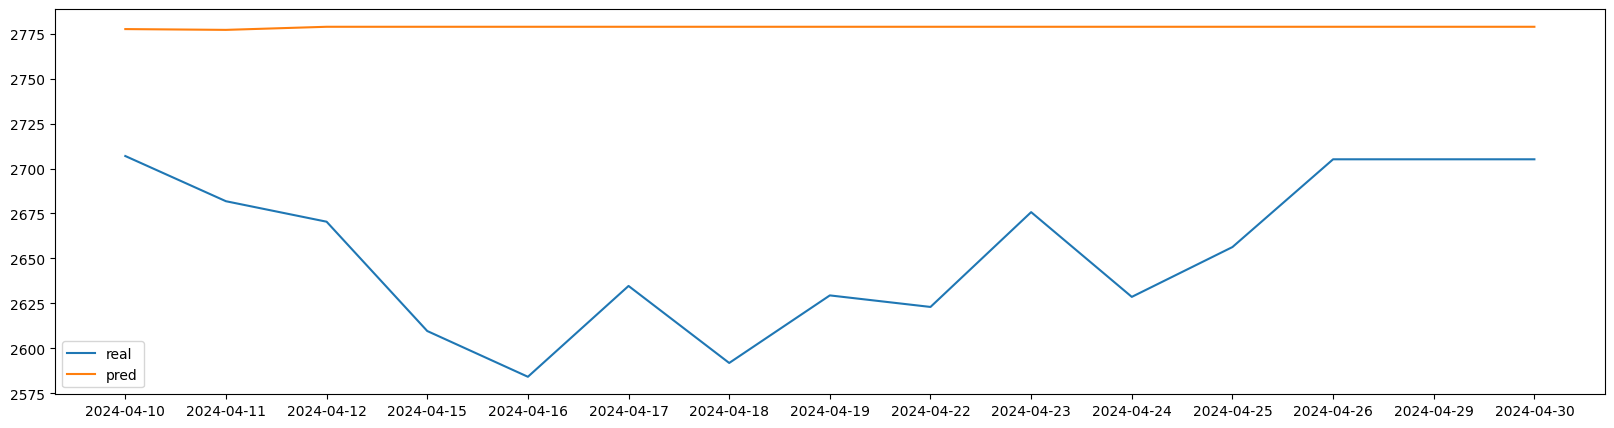

In [42]:
# recent untested data prediction
plt.figure(figsize=(20, 5))
plt.plot(df.iloc[LAST_N:, 0:1].values.reshape(-1), df_pred['y'], label='real')
plt.plot(df.iloc[LAST_N:, 0:1].values.reshape(-1), df_pred['pred'], label='pred')
plt.legend()
plt.show()

In [43]:
df_test_result = pd.merge(test_y, df['Date'], left_index=True, right_index=True, how='left')
df_test_result['pred'] = pred
df_test_result = df_test_result[['Date', 'pred', 'kospi_shift']]
df_test_result['diff'] = df_test_result['pred'] - df_test_result['kospi_shift']
df_test_result = df_test_result.sort_index(ascending=True)
df_test_result

,Date,pred,kospi_shift,diff
6,2003-12-09,815.303986,794.640015,20.663971
17,2003-12-24,796.647153,788.849976,7.797178
24,2004-01-02,828.407934,824.099976,4.307958
63,2004-02-26,828.268740,883.419983,-55.151243
80,2004-03-22,828.946688,866.169983,-37.223295
...,...,...,...,...
5250,2024-01-15,2569.438777,2497.590088,71.848689
5260,2024-01-29,2551.027224,2498.810059,52.217165
5264,2024-02-02,2613.471838,2591.310059,22.161779
5291,2024-03-12,2697.955317,2693.570068,4.385248


In [44]:
(np.square(df_test_result['diff']).sum()/len(df_test_result))**0.5

49.41305828832358

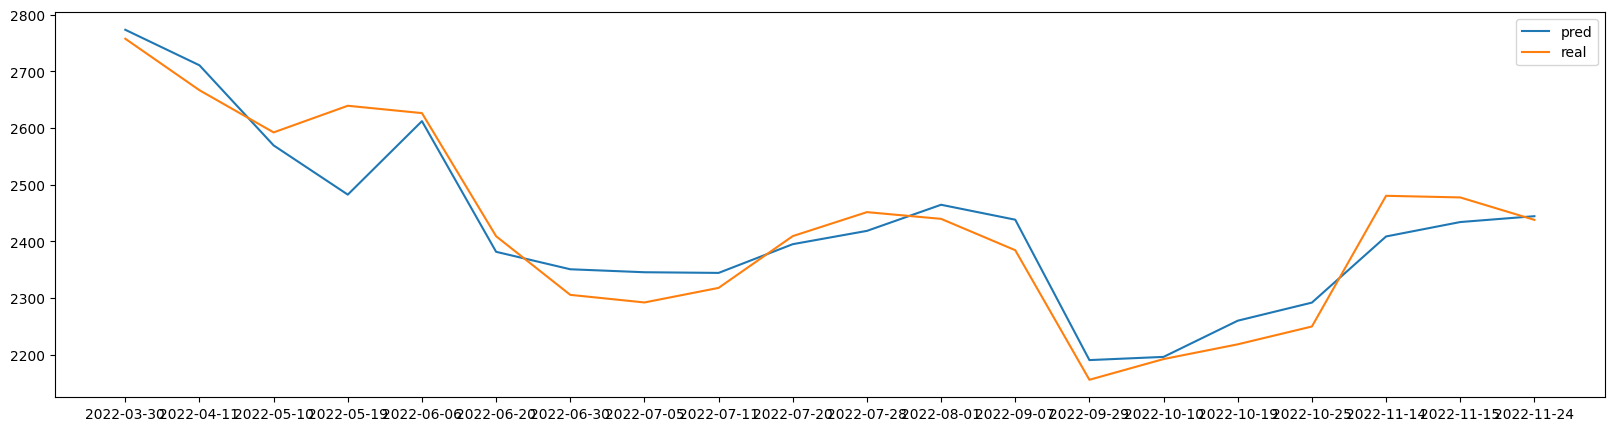

In [45]:
start = -60
end = -40
plt.figure(figsize=(20, 5))
plt.plot(df_test_result.iloc[start:end, 0:1].values.reshape(-1), df_test_result.iloc[start:end, 1:2].values, label='pred')
plt.plot(df_test_result.iloc[start:end, 0:1].values.reshape(-1), df_test_result.iloc[start:end, 2:3].values, label='real')
plt.legend()
plt.show()